# CAM
사전 학습된 ResNet-18의 피처 맵을 활용해 CAM 구현한다.  
CAM은 GAP을 적용하기 전의 피처 맵을 활용하므로 ResNet-18 모델의 마지막 layer를 제외한 모든 layer를 추출한다.

In [6]:
# ResNet 모델 특징 추출
from torch import nn
from torchvision import models


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()
features = nn.Sequential(*list(model.children())[:-2])

ResNet 모델 구조는 하나의 입력 줄기(con1, bn1, relu, maxpool), 네 개의 스테이지(layer1, 2, 3, 4), avgpool, FC로 설계됐다.  
avgpool, FC는 분류기에 속하므로 [:-2]를 통해 피처만 연산하는 계층을 features 변수로 저장한다.

모델과 마지막 CL의 출력 피처 맵을 구현했다면 해당 기능을 통해 이미지의 피처 맵과 FC의 가중치를 가져온다.

In [7]:
from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("/content/airplane.jpg")
target = transform(image).unsqueeze(0)

output = model(target)
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


차원을 동일하게 맞춰준다.

이제 CAM 행렬을 계산한다.

In [8]:
import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

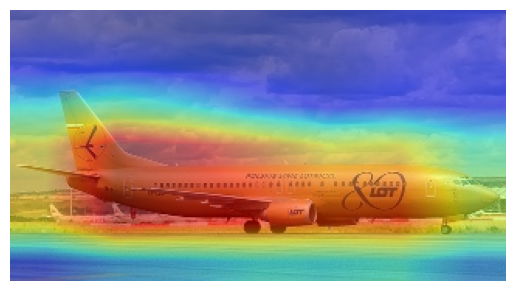

In [9]:
import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()